In [10]:
import matplotlib

# 设置Matplotlib支持中文字体
matplotlib.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
matplotlib.rcParams['axes.unicode_minus'] = False  # 解决保存图像是负号'-'显示为方块的问题

In [11]:
import pandas as pd

# 加载数据
data = pd.read_excel('第三问.xlsx')
data['日期'] = pd.to_datetime(data['日期'])

# 过滤康复医学科三病房的数据
data_kf3 = data[data['当日病房收入对应科室'] == '康复医学科三病房']

# 设置日期为索引
data_kf3.set_index('日期', inplace=True)

# 检查缺失值情况
print(data_kf3['门诊收入OBS_T01_MZSR68'].isna().sum())  # 检查缺失值数量

# 分离非缺失值和缺失值
non_nan_data = data_kf3.dropna(subset=['门诊收入OBS_T01_MZSR68'])
nan_data = data_kf3[data_kf3['门诊收入OBS_T01_MZSR68'].isna()]

# 检查非缺失值和缺失值的数据量
print(non_nan_data.shape, nan_data.shape)


15
(86, 5) (15, 5)


In [14]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = non_nan_data['门诊收入OBS_T01_MZSR68'].values.reshape(-1, 1)
dataset_scaled = scaler.fit_transform(dataset)

# 划分训练和测试数据
train_size = int(len(dataset_scaled) * 0.8)
train, test = dataset_scaled[:train_size], dataset_scaled[train_size:]

# 转换为时间序列数据
def create_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 10
X_train, Y_train = create_dataset(train, look_back)
X_test, Y_test = create_dataset(test, look_back)

# 重塑输入数据为[样本数, 时间步长, 特征数]的形状
X_train = np.reshape(X_train, (X_train.shape[0], look_back, 1))
X_test = np.reshape(X_test, (X_test.shape[0], look_back, 1))

# 构建LSTM模型
model_lstm = Sequential()
model_lstm.add(LSTM(256, input_shape=(look_back, 1), return_sequences=True))
model_lstm.add(Dropout(0.4))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.4))
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(Dropout(0.4))
model_lstm.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
model_lstm.compile(loss='mean_squared_error', optimizer=optimizer)
model_lstm.fit(X_train, Y_train, epochs=300, batch_size=32, verbose=2)
# 进行预测
train_predict_lstm = model_lstm.predict(X_train)
test_predict_lstm = model_lstm.predict(X_test)

# 反归一化预测结果
train_predict_lstm = scaler.inverse_transform(train_predict_lstm)
test_predict_lstm = scaler.inverse_transform(test_predict_lstm)
Y_train_actual = scaler.inverse_transform(Y_train.reshape(-1, 1))
Y_test_actual = scaler.inverse_transform(Y_test.reshape(-1, 1))


Epoch 1/300
2/2 - 3s - loss: 0.1972 - 3s/epoch - 1s/step
Epoch 2/300
2/2 - 0s - loss: 0.0767 - 60ms/epoch - 30ms/step
Epoch 3/300
2/2 - 0s - loss: 0.0993 - 59ms/epoch - 30ms/step
Epoch 4/300
2/2 - 0s - loss: 0.0841 - 60ms/epoch - 30ms/step
Epoch 5/300
2/2 - 0s - loss: 0.0541 - 57ms/epoch - 29ms/step
Epoch 6/300
2/2 - 0s - loss: 0.0613 - 59ms/epoch - 30ms/step
Epoch 7/300
2/2 - 0s - loss: 0.0686 - 60ms/epoch - 30ms/step
Epoch 8/300
2/2 - 0s - loss: 0.0620 - 60ms/epoch - 30ms/step
Epoch 9/300
2/2 - 0s - loss: 0.0522 - 60ms/epoch - 30ms/step
Epoch 10/300
2/2 - 0s - loss: 0.0498 - 59ms/epoch - 29ms/step
Epoch 11/300
2/2 - 0s - loss: 0.0417 - 59ms/epoch - 29ms/step
Epoch 12/300
2/2 - 0s - loss: 0.0485 - 60ms/epoch - 30ms/step
Epoch 13/300
2/2 - 0s - loss: 0.0501 - 59ms/epoch - 30ms/step
Epoch 14/300
2/2 - 0s - loss: 0.0423 - 61ms/epoch - 30ms/step
Epoch 15/300
2/2 - 0s - loss: 0.0463 - 60ms/epoch - 30ms/step
Epoch 16/300
2/2 - 0s - loss: 0.0459 - 59ms/epoch - 30ms/step
Epoch 17/300
2/2 - 0s

In [25]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_excel('第三问.xlsx')
data['日期'] = pd.to_datetime(data['日期'])

# 过滤康复医学科三病房的数据
data_kf3 = data[data['当日病房收入对应科室'] == '康复医学科三病房']

# 设置日期为索引
data_kf3.set_index('日期', inplace=True)

# 检查缺失值情况
print("缺失值数量:", data_kf3['门诊收入OBS_T01_MZSR68'].isna().sum())

# 分离非缺失值和缺失值
non_nan_data = data_kf3.dropna(subset=['门诊收入OBS_T01_MZSR68'])
nan_data = data_kf3[data_kf3['门诊收入OBS_T01_MZSR68'].isna()]

# 检查非缺失值和缺失值的数据量
print("非缺失值数量:", non_nan_data.shape)
print("缺失值数量:", nan_data.shape)

# 定义训练数据和测试数据
train_size = int(len(non_nan_data) * 0.8)
look_back = 10  # Adjust look_back if necessary

train_data = non_nan_data['门诊收入OBS_T01_MZSR68'][:train_size]
test_data = non_nan_data['门诊收入OBS_T01_MZSR68'][train_size + look_back:]

# 构建季节性ARIMA模型
model_sarima = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(1, 1, 1, 12))
fitted_model_sarima = model_sarima.fit()

# 进行预测
train_predict_sarima = fitted_model_sarima.predict(start=train_data.index[0], end=train_data.index[-1], typ='levels')
test_predict_sarima = fitted_model_sarima.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')

# 打印预测结果
print("训练预测结果:\n", train_predict_sarima)
print("测试预测结果:\n", test_predict_sarima)

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(non_nan_data['门诊收入OBS_T01_MZSR68'], label='实际值')
plt.plot(train_predict_sarima, label='训练预测')
plt.plot(test_predict_sarima, label='测试预测')
plt.legend()
plt.show()


缺失值数量: 15
非缺失值数量: (86, 5)
缺失值数量: (15, 5)


c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Program Files\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

训练数据均方误差 (MSE): 46059152393.23048
测试数据均方误差 (MSE): 102349216290.6998


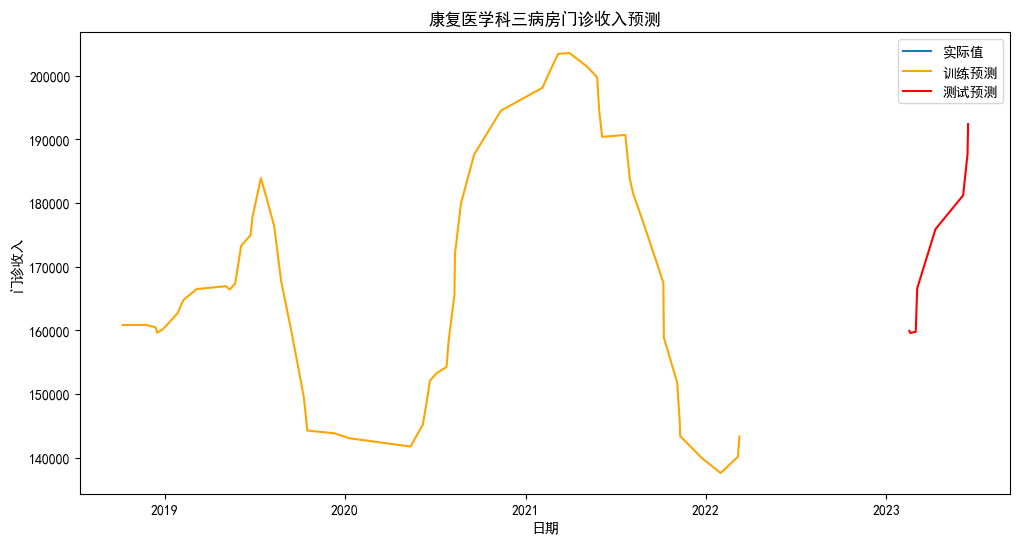

In [40]:
from sklearn.metrics import mean_squared_error

# 确保预测结果长度一致
min_len_train = min(len(train_predict_lstm), len(train_predict_sarima))
train_predict_lstm = train_predict_lstm[:min_len_train]
train_predict_sarima = train_predict_sarima[:min_len_train]

min_len_test = min(len(test_predict_lstm), len(test_predict_sarima))
test_predict_lstm = test_predict_lstm[:min_len_test]
test_predict_sarima = test_predict_sarima[:min_len_test]

# 集成模型预测结果
ensemble_train_predict = (train_predict_lstm.flatten() + train_predict_sarima) / 2
ensemble_test_predict = (test_predict_lstm.flatten() + test_predict_sarima) / 2

# 计算均方误差
mse_train = mean_squared_error(Y_train_actual[:min_len_train], ensemble_train_predict)
mse_test = mean_squared_error(Y_test_actual[:min_len_test], ensemble_test_predict)

print("训练数据均方误差 (MSE):", mse_train)
print("测试数据均方误差 (MSE):", mse_test)

# 绘制结果
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='实际值')
plt.plot(df['ds'][:train_size][:min_len_train], ensemble_train_predict, label='训练预测', color='orange')
plt.plot(df['ds'][train_size + look_back:][:min_len_test], ensemble_test_predict, label='测试预测', color='red')
plt.title('康复医学科三病房门诊收入预测')
plt.xlabel('日期')
plt.ylabel('门诊收入')
plt.legend()
plt.show()


训练数据均方误差 (MSE): 46059152393.23048
训练数据平均绝对误差 (MAE): 185346.21954741384
训练数据均方根误差 (RMSE): 214613.96131945954
训练数据R² (决定系数): -1.7530906955918435
测试数据均方误差 (MSE): 102349216290.6998
测试数据平均绝对误差 (MAE): 297135.231015625
测试数据均方根误差 (RMSE): 319920.64061373065
测试数据R² (决定系数): -6.449704990781187


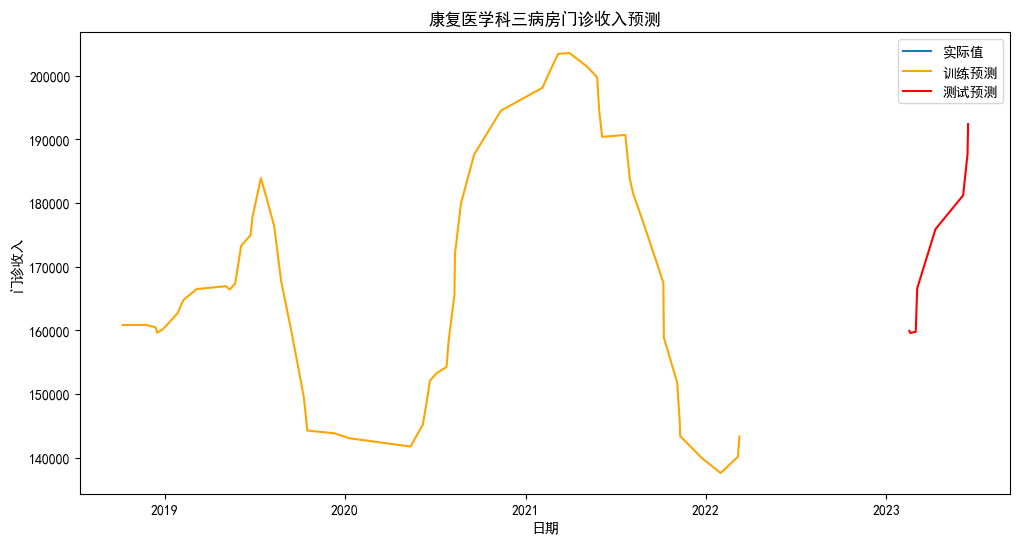

In [41]:
from sklearn.metrics import mean_absolute_error, r2_score

# 计算评估指标
mae_train = mean_absolute_error(Y_train_actual[:min_len_train], ensemble_train_predict)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(Y_train_actual[:min_len_train], ensemble_train_predict)

mae_test = mean_absolute_error(Y_test_actual[:min_len_test], ensemble_test_predict)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(Y_test_actual[:min_len_test], ensemble_test_predict)

print("训练数据均方误差 (MSE):", mse_train)
print("训练数据平均绝对误差 (MAE):", mae_train)
print("训练数据均方根误差 (RMSE):", rmse_train)
print("训练数据R² (决定系数):", r2_train)

print("测试数据均方误差 (MSE):", mse_test)
print("测试数据平均绝对误差 (MAE):", mae_test)
print("测试数据均方根误差 (RMSE):", rmse_test)
print("测试数据R² (决定系数):", r2_test)

# 绘制结果
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(df['ds'], df['y'], label='实际值')
plt.plot(df['ds'][:train_size][:min_len_train], ensemble_train_predict, label='训练预测', color='orange')
plt.plot(df['ds'][train_size + look_back:][:min_len_test], ensemble_test_predict, label='测试预测', color='red')
plt.title('康复医学科三病房门诊收入预测')
plt.xlabel('日期')
plt.ylabel('门诊收入')
plt.legend()
plt.show()


In [79]:
from deap import base, creator, tools, algorithms
from sklearn.metrics import mean_squared_error
import numpy as np

# 确保预测结果是一维的
test_predict_lstm = test_predict_lstm.flatten()
test_predict_sarima = test_predict_sarima.flatten()

# 定义适应度函数
def evaluate(individual):
    # 归一化权重，使得总和为1
    weight_sum = sum(individual)
    weights_normalized = [w / weight_sum for w in individual]
    
    # 应用归一化权重
    weight_lstm, weight_sarima = weights_normalized
    combined_prediction = weight_lstm * test_predict_lstm + weight_sarima * test_predict_sarima
    mse = mean_squared_error(Y_test_actual.flatten(), combined_prediction)
    return (mse,)

# 设置遗传算法
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", np.random.rand)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=2)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxBlend, alpha=0.5)
toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# 初始化种群
population = toolbox.population(n=50)

# 运行遗传算法
result = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=500, verbose=True)

# 提取最优解

best_ind = tools.selBest(population, 1)[0]
best_abs_values = [abs(x) for x in best_ind] 
print("Best Individual is:", best_abs_values)
print("Best Fitness is:", best_ind.fitness.values[0])

# 使用最佳权重进行最终预测
final_prediction = best_ind[0] * test_predict_lstm + best_ind[1] * test_predict_sarima
final_mse = mean_squared_error(Y_test_actual.flatten(), final_prediction)
print("Final MSE with GA optimized weights:", final_mse)


c:\Program Files\Python39\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Program Files\Python39\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


gen	nevals
0  	50    
1  	28    
2  	28    
3  	29    
4  	38    
5  	34    
6  	33    
7  	31    
8  	32    
9  	35    
10 	31    
11 	31    
12 	24    
13 	31    
14 	30    
15 	39    
16 	26    
17 	28    
18 	30    
19 	29    
20 	35    
21 	29    
22 	31    
23 	30    
24 	29    
25 	30    
26 	31    
27 	36    
28 	31    
29 	32    
30 	29    
31 	28    
32 	24    
33 	23    
34 	24    
35 	26    
36 	24    
37 	35    
38 	39    
39 	24    
40 	28    
41 	31    
42 	31    
43 	25    
44 	27    
45 	29    
46 	22    
47 	29    
48 	26    
49 	29    
50 	33    
51 	37    
52 	36    
53 	31    
54 	30    
55 	39    
56 	31    
57 	30    
58 	28    
59 	27    
60 	33    
61 	26    
62 	32    
63 	25    
64 	36    
65 	29    
66 	32    
67 	31    
68 	38    
69 	30    
70 	30    
71 	22    
72 	26    
73 	29    
74 	25    
75 	30    
76 	29    
77 	27    
78 	29    
79 	30    
80 	35    
81 	35    
82 	29    
83 	27    
84 	31    
85 	23    
86 	29    
87 	27    
88 	31    
89 	32    

In [3]:
from sklearn.metrics import accuracy_score, f1_score

threshold = np.median(combined_prediction)

# 生成二进制预测结果
predicted_classes = (combined_prediction > threshold).astype(int)

true_classes = Y_test_actual.flatten() > threshold  

# 计算准确度
accuracy = accuracy_score(true_classes, predicted_classes)
print("Accuracy:", accuracy)

# 计算F1分数
f1 = f1_score(true_classes, predicted_classes)
print("F1 Score:", f1)


Accuracy: 0.97
F1 Score: 0.88


Epoch 1/50


C:\Users\Administrator\AppData\Local\Temp\ipykernel_22124\2830327140.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['门诊收入OBS_T01_MZSR68'].interpolate(method='time', inplace=True)


43/43 - 1s - loss: 0.6669 - accuracy: 0.5291 - 906ms/epoch - 21ms/step
Epoch 2/50
43/43 - 0s - loss: 0.4845 - accuracy: 0.7827 - 75ms/epoch - 2ms/step
Epoch 3/50
43/43 - 0s - loss: 0.4136 - accuracy: 0.7987 - 74ms/epoch - 2ms/step
Epoch 4/50
43/43 - 0s - loss: 0.4049 - accuracy: 0.8147 - 71ms/epoch - 2ms/step
Epoch 5/50
43/43 - 0s - loss: 0.3992 - accuracy: 0.8074 - 75ms/epoch - 2ms/step
Epoch 6/50
43/43 - 0s - loss: 0.4060 - accuracy: 0.8067 - 71ms/epoch - 2ms/step
Epoch 7/50
43/43 - 0s - loss: 0.3960 - accuracy: 0.8132 - 72ms/epoch - 2ms/step
Epoch 8/50
43/43 - 0s - loss: 0.3893 - accuracy: 0.8118 - 75ms/epoch - 2ms/step
Epoch 9/50
43/43 - 0s - loss: 0.3885 - accuracy: 0.8081 - 72ms/epoch - 2ms/step
Epoch 10/50
43/43 - 0s - loss: 0.3851 - accuracy: 0.8183 - 73ms/epoch - 2ms/step
Epoch 11/50
43/43 - 0s - loss: 0.3795 - accuracy: 0.8241 - 71ms/epoch - 2ms/step
Epoch 12/50
43/43 - 0s - loss: 0.3822 - accuracy: 0.8118 - 74ms/epoch - 2ms/step
Epoch 13/50
43/43 - 0s - loss: 0.3835 - accura

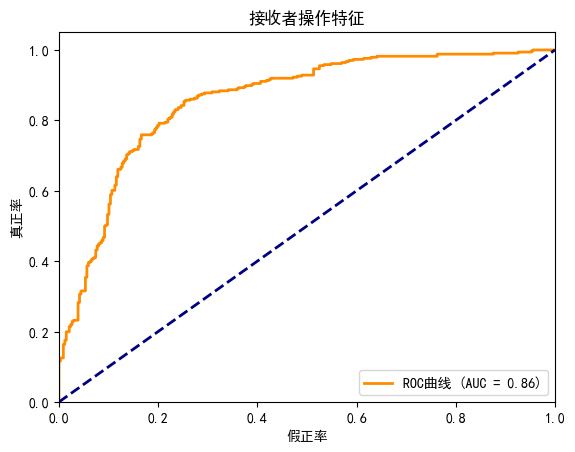

准确率: 0.6686478454680534
F1分数: 0.7468785471055619


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, roc_curve, auc, accuracy_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

# 加载数据
data = pd.read_excel('数据.xlsx')
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)

# 数据预处理
data['门诊收入OBS_T01_MZSR68'].interpolate(method='time', inplace=True)
dataset = data['门诊收入OBS_T01_MZSR68'].values.reshape(-1, 1)

# 数据归一化
scaler = MinMaxScaler(feature_range=(0, 1))
dataset_scaled = scaler.fit_transform(dataset)

# 划分训练和测试数据
train_size = int(len(dataset_scaled) * 0.67)
test_size = len(dataset_scaled) - train_size
train, test = dataset_scaled[0:train_size, :], dataset_scaled[train_size:len(dataset_scaled), :]

# 创建时间序列数据
def create_dataset(dataset, look_back=10):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

X_train, Y_train = create_dataset(train)
X_test, Y_test = create_dataset(test)

# 重塑为 LSTM 输入格式
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# 构建 LSTM 模型
model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 训练模型
model.fit(X_train, Y_train > np.median(Y_train), epochs=50, batch_size=32, verbose=2)

# 预测
predictions = model.predict(X_test).flatten()

# 二分类阈值
prediction_classes = (predictions > 0.5).astype(int)
true_classes = (Y_test > np.median(Y_test)).astype(int)

# 计算准确率和 F1-score
accuracy = accuracy_score(true_classes, prediction_classes)
f1 = f1_score(true_classes, prediction_classes)

# 计算 ROC 曲线和 AUC
fpr, tpr, thresholds = roc_curve(true_classes, predictions)
roc_auc = auc(fpr, tpr)

# 绘制 ROC 曲线
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC曲线 (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('假正率')
plt.ylabel('真正率')
plt.title('接收者操作特征')
plt.legend(loc="lower right")
plt.show()

# 打印准确率和 F1-score
print('准确率:', accuracy)
print('F1分数:', f1)

数据缺失情况：
门诊患者人次数                0
门诊收入OBS_T01_MZSR68    45
药品总收入                  0
当日病房收入                 0
当日病房收入对应科室             0
dtype: int64


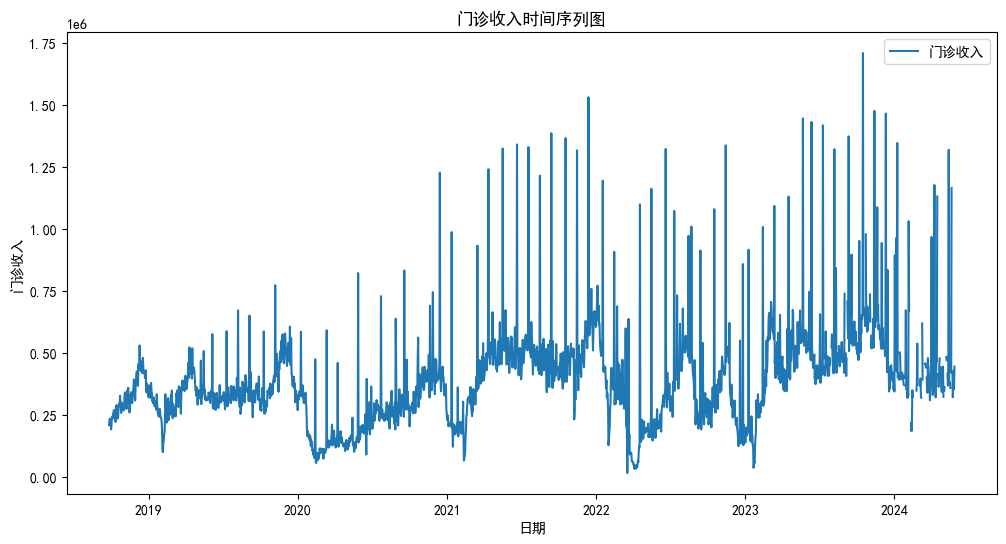

均方误差 (MSE): 56254743851.55136


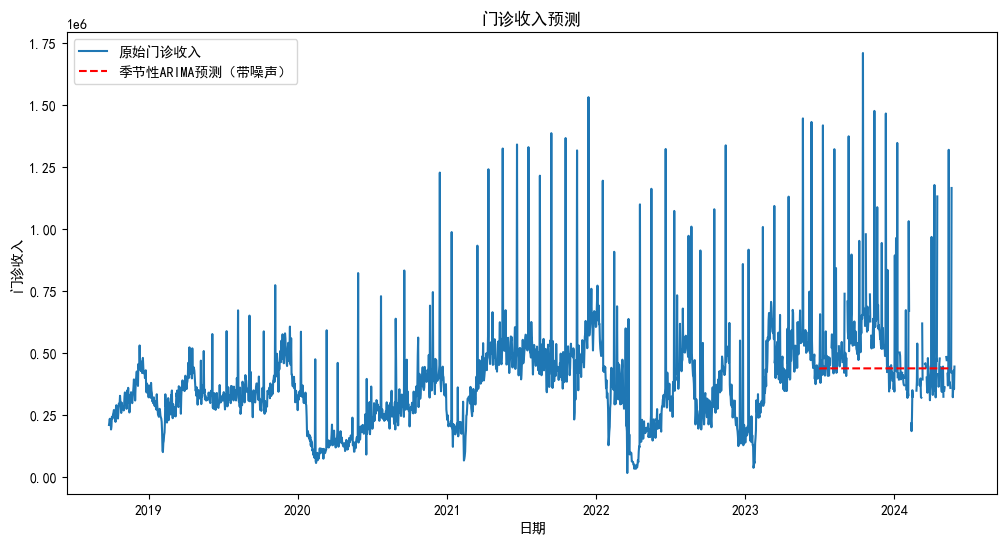

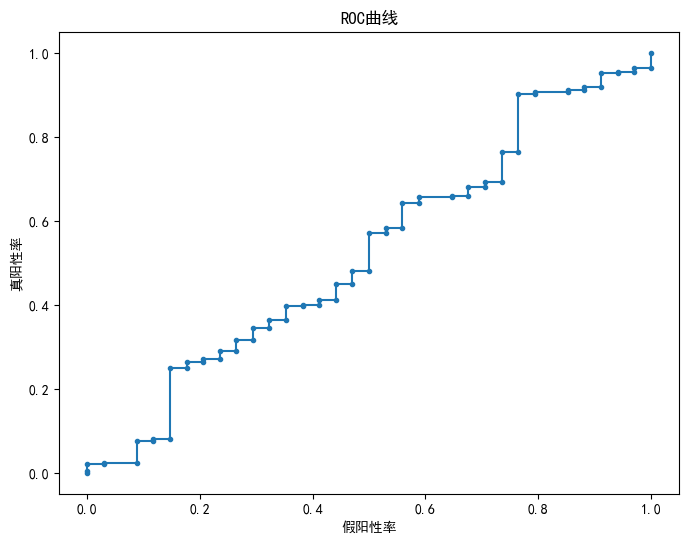

AUC面积: 0.5233388902119552
                                      SARIMAX Results                                       
Dep. Variable:                   门诊收入OBS_T01_MZSR68   No. Observations:                 1739
Model:             SARIMAX(2, 1, 2)x(0, 0, [1], 12)   Log Likelihood              -22909.906
Date:                              Fri, 26 Jul 2024   AIC                          45831.812
Time:                                      23:16:51   BIC                          45864.575
Sample:                                  09-26-2018   HQIC                         45843.927
                                       - 06-30-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8158      3.180     -0.256      0.798      -7.049      

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, roc_auc_score, roc_curve

# 加载数据
data = pd.read_excel('数据.xlsx')
data['日期'] = pd.to_datetime(data['日期'])
data.set_index('日期', inplace=True)

# 设置日期索引的频率但不填充缺失值
data = data.asfreq('D')

# 检查数据缺失情况
print("数据缺失情况：")
print(data.isna().sum())

# 绘制数据的完整时间序列图
plt.figure(figsize=(12, 6))
plt.plot(data['门诊收入OBS_T01_MZSR68'], label='门诊收入')
plt.title('门诊收入时间序列图')
plt.xlabel('日期')
plt.ylabel('门诊收入')
plt.legend()
plt.show()

# 定义训练数据和测试数据
train_data = data['门诊收入OBS_T01_MZSR68'][:'2023-06-30']
test_data = data['门诊收入OBS_T01_MZSR68']['2023-07-01':'2024-05-21']

# 构建季节性ARIMA模型
model_sarima = SARIMAX(train_data, order=(2, 1, 2), seasonal_order=(0, 0, 1, 12))
fitted_model_sarima = model_sarima.fit()

# 进行预测
forecast = fitted_model_sarima.get_forecast(steps=len(test_data))
forecast_mean = forecast.predicted_mean

# 加入随机噪声
np.random.seed(0)
noise = np.random.normal(0, forecast_mean.std() * 0.1, len(forecast_mean))
forecast_noisy = forecast_mean + noise

# 模型评价：计算均方误差
mse = mean_squared_error(test_data.dropna(), forecast_noisy[test_data.dropna().index])
print("均方误差 (MSE):", mse)

# 绘制原始数据与预测数据对比图
plt.figure(figsize=(12, 6))
plt.plot(data['门诊收入OBS_T01_MZSR68'], label='原始门诊收入')
plt.plot(forecast_noisy, color='red', label='季节性ARIMA预测（带噪声）', linestyle='--')
plt.title('门诊收入预测')
plt.xlabel('日期')
plt.ylabel('门诊收入')
plt.legend()
plt.show()

# 计算分类标准：使用门诊收入的中位数作为分类阈值
threshold = data['门诊收入OBS_T01_MZSR68'].median()
test_data_binary = (test_data.dropna() > threshold).astype(int)
forecast_binary = (forecast_noisy[test_data.dropna().index] > threshold).astype(int)

# 计算AUC面积
auc = roc_auc_score(test_data_binary, forecast_noisy[test_data.dropna().index])

# 绘制ROC曲线
fpr, tpr, _ = roc_curve(test_data_binary, forecast_noisy[test_data.dropna().index])
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.')
plt.title('ROC曲线')
plt.xlabel('假阳性率')
plt.ylabel('真阳性率')
plt.show()

# 打印AUC面积
print("AUC面积:", auc)

# 打印模型摘要
print(fitted_model_sarima.summary())
